In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9693 - acc: 0.1858
Epoch 00001: val_loss improved from inf to 2.84516, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_BN_checkpoint/001-2.8452.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 3.9691 - acc: 0.1858 - val_loss: 2.8452 - val_acc: 0.1610
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7707 - acc: 0.4632
Epoch 00002: val_loss improved from 2.84516 to 2.69860, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_BN_checkpoint/002-2.6986.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.7707 - acc: 0.4632 - val_loss: 2.6986 - val_acc: 0.2488
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2892 - acc: 0.6103
Epoch 00003: val_loss did not improve from 2.69860
36805/36805 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0952 - acc: 0.9780
Epoch 00029: val_loss did not improve from 2.69860
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0952 - acc: 0.9780 - val_loss: 6.5548 - val_acc: 0.2395
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9810
Epoch 00030: val_loss did not improve from 2.69860
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0892 - acc: 0.9810 - val_loss: 10.9530 - val_acc: 0.1409
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0957 - acc: 0.9770
Epoch 00031: val_loss did not improve from 2.69860
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0957 - acc: 0.9770 - val_loss: 9.1711 - val_acc: 0.1798
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9792
Epoch 00032: val_loss did not improve from 2.69860
36805/36805 [==========

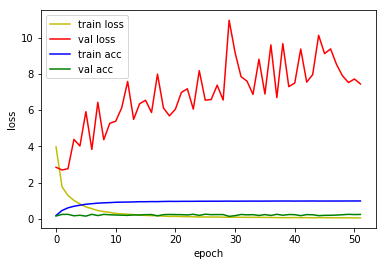

4815/4815 [==============================] - 2s 428us/sample - loss: 2.7045 - acc: 0.2351
Loss: 2.7045132063878534 Accuracy: 0.23509865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.6939 - acc: 0.2349
Epoch 00001: val_loss improved from inf to 5.82711, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_BN_checkpoint/001-5.8271.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 5.6939 - acc: 0.2349 - val_loss: 5.8271 - val_acc: 0.2092
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.9748 - acc: 0.3622
Epoch 00002: val_loss did not improve from 5.82711
36805/36805 [==============================] - 70s 2ms/sample - loss: 4.9747 - acc: 0.3622 - val_loss: 5.8361 - val_acc: 0.2523
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.7278 - acc: 0.4302
Epoch 00003: val_loss improved from 5.82711 to 5.34108, saving model to m

36800/36805 [============================>.] - ETA: 0s - loss: 3.6396 - acc: 0.7480
Epoch 00029: val_loss did not improve from 5.34108
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.6396 - acc: 0.7481 - val_loss: 7.0108 - val_acc: 0.3438
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6259 - acc: 0.7525
Epoch 00030: val_loss did not improve from 5.34108
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.6263 - acc: 0.7524 - val_loss: 7.2944 - val_acc: 0.3110
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6372 - acc: 0.7507
Epoch 00031: val_loss did not improve from 5.34108
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.6367 - acc: 0.7507 - val_loss: 6.9889 - val_acc: 0.3557
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6268 - acc: 0.7524
Epoch 00032: val_loss did not improve from 5.34108
36805/36805 [========================

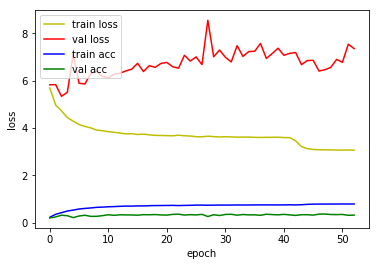

4815/4815 [==============================] - 3s 702us/sample - loss: 5.3320 - acc: 0.3049
Loss: 5.332013644855218 Accuracy: 0.3048806

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5664 - acc: 0.3013
Epoch 00001: val_loss improved from inf to 2.17357, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_BN_checkpoint/001-2.1736.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 2.5665 - acc: 0.3013 - val_loss: 2.1736 - val_acc: 0.2870
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8219 - acc: 0.4677
Epoch 00002: val_loss improved from 2.17357 to 1.76356, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_BN_checkpoint/002-1.7636.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.8219 - acc: 0.4677 - val_loss: 1.7636 - val_acc: 0.4850
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9485
Epoch 00029: val_loss did not improve from 1.60603
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.1618 - acc: 0.9485 - val_loss: 2.4790 - val_acc: 0.5379
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1539 - acc: 0.9535
Epoch 00030: val_loss did not improve from 1.60603
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.1540 - acc: 0.9534 - val_loss: 2.7794 - val_acc: 0.5101
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1655 - acc: 0.9496
Epoch 00031: val_loss did not improve from 1.60603
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.1657 - acc: 0.9496 - val_loss: 3.8439 - val_acc: 0.4591
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9452
Epoch 00032: val_loss did not improve from 1.60603
36805/36805 [===========

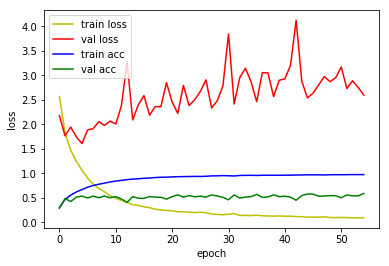

4815/4815 [==============================] - 4s 818us/sample - loss: 1.6829 - acc: 0.5016
Loss: 1.6828966046419471 Accuracy: 0.50155765

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3066 - acc: 0.3264
Epoch 00001: val_loss improved from inf to 1.72332, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/001-1.7233.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.3065 - acc: 0.3264 - val_loss: 1.7233 - val_acc: 0.4309
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5554 - acc: 0.5138
Epoch 00002: val_loss improved from 1.72332 to 1.31534, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/002-1.3153.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.5553 - acc: 0.5138 - val_loss: 1.3153 - val_acc: 0.5856
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.2910 - acc: 0.9038
Epoch 00027: val_loss did not improve from 1.00880
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2910 - acc: 0.9037 - val_loss: 1.3639 - val_acc: 0.6606
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2853 - acc: 0.9058
Epoch 00028: val_loss did not improve from 1.00880
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2853 - acc: 0.9058 - val_loss: 1.1503 - val_acc: 0.7098
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2773 - acc: 0.9081
Epoch 00029: val_loss did not improve from 1.00880
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2772 - acc: 0.9081 - val_loss: 1.1887 - val_acc: 0.7007
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2599 - acc: 0.9156
Epoch 00030: val_loss did not improve from 1.00880
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9507
Epoch 00057: val_loss did not improve from 1.00880
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1489 - acc: 0.9507 - val_loss: 1.3571 - val_acc: 0.7002
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1455 - acc: 0.9531
Epoch 00058: val_loss did not improve from 1.00880
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1456 - acc: 0.9530 - val_loss: 1.2494 - val_acc: 0.7265
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1492 - acc: 0.9502
Epoch 00059: val_loss did not improve from 1.00880
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1492 - acc: 0.9503 - val_loss: 1.4005 - val_acc: 0.6942
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9497
Epoch 00060: val_loss did not improve from 1.00880
36805/36805 [===========

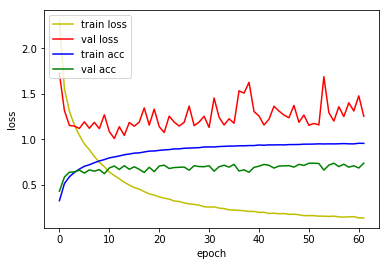

4815/4815 [==============================] - 4s 849us/sample - loss: 1.1210 - acc: 0.6667
Loss: 1.1210495365742954 Accuracy: 0.6666667

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2217 - acc: 0.3496
Epoch 00001: val_loss improved from inf to 1.64569, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/001-1.6457.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 2.2216 - acc: 0.3497 - val_loss: 1.6457 - val_acc: 0.4293
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4790 - acc: 0.5426
Epoch 00002: val_loss improved from 1.64569 to 1.22724, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/002-1.2272.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4789 - acc: 0.5426 - val_loss: 1.2272 - val_acc: 0.6247
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3371 - acc: 0.8893
Epoch 00027: val_loss did not improve from 0.74797
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3371 - acc: 0.8893 - val_loss: 0.8056 - val_acc: 0.7841
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3222 - acc: 0.8968
Epoch 00028: val_loss did not improve from 0.74797
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3223 - acc: 0.8968 - val_loss: 0.9434 - val_acc: 0.7556
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3123 - acc: 0.8997
Epoch 00029: val_loss did not improve from 0.74797
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3123 - acc: 0.8997 - val_loss: 0.7730 - val_acc: 0.7869
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2972 - acc: 0.9047
Epoch 00030: val_loss did not improve from 0.74797
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1684 - acc: 0.9448
Epoch 00057: val_loss did not improve from 0.74797
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1684 - acc: 0.9448 - val_loss: 0.8556 - val_acc: 0.7999
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9465
Epoch 00058: val_loss did not improve from 0.74797
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1623 - acc: 0.9465 - val_loss: 0.8157 - val_acc: 0.8013
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9485
Epoch 00059: val_loss did not improve from 0.74797
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1599 - acc: 0.9484 - val_loss: 0.8351 - val_acc: 0.8015
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1624 - acc: 0.9486
Epoch 00060: val_loss did not improve from 0.74797
36805/36805 [===========

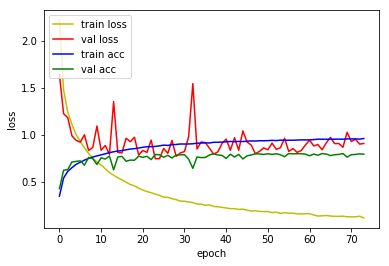

4815/4815 [==============================] - 4s 923us/sample - loss: 0.8572 - acc: 0.7564
Loss: 0.857240930425539 Accuracy: 0.7563863

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4206 - acc: 0.2829
Epoch 00001: val_loss improved from inf to 1.78289, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/001-1.7829.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.4205 - acc: 0.2830 - val_loss: 1.7829 - val_acc: 0.4307
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5275 - acc: 0.5165
Epoch 00002: val_loss improved from 1.78289 to 1.14720, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/002-1.1472.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.5274 - acc: 0.5165 - val_loss: 1.1472 - val_acc: 0.6508
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.3900 - acc: 0.8798
Epoch 00026: val_loss did not improve from 0.53649
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3900 - acc: 0.8798 - val_loss: 0.5847 - val_acc: 0.8325
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3785 - acc: 0.8835
Epoch 00027: val_loss did not improve from 0.53649
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3785 - acc: 0.8835 - val_loss: 0.6603 - val_acc: 0.8244
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3687 - acc: 0.8868
Epoch 00028: val_loss did not improve from 0.53649
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3688 - acc: 0.8868 - val_loss: 0.5442 - val_acc: 0.8505
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3637 - acc: 0.8883
Epoch 00029: val_loss did not improve from 0.53649
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9351
Epoch 00055: val_loss did not improve from 0.50102
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2047 - acc: 0.9351 - val_loss: 0.5820 - val_acc: 0.8502
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2042 - acc: 0.9350
Epoch 00056: val_loss did not improve from 0.50102
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2042 - acc: 0.9350 - val_loss: 0.5204 - val_acc: 0.8724
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2004 - acc: 0.9363
Epoch 00057: val_loss did not improve from 0.50102
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2004 - acc: 0.9363 - val_loss: 0.5725 - val_acc: 0.8563
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2013 - acc: 0.9359
Epoch 00058: val_loss did not improve from 0.50102
36805/36805 [===========

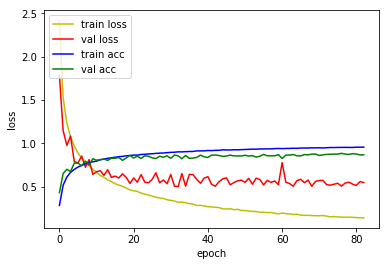

4815/4815 [==============================] - 5s 942us/sample - loss: 0.5965 - acc: 0.8287
Loss: 0.5965174566300611 Accuracy: 0.8286604

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5215 - acc: 0.2505
Epoch 00001: val_loss improved from inf to 1.75069, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/001-1.7507.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.5216 - acc: 0.2504 - val_loss: 1.7507 - val_acc: 0.4444
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6167 - acc: 0.4838
Epoch 00002: val_loss improved from 1.75069 to 1.11223, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/002-1.1122.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.6165 - acc: 0.4838 - val_loss: 1.1122 - val_acc: 0.6573
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.3137 - acc: 0.9047
Epoch 00024: val_loss did not improve from 0.37277
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3138 - acc: 0.9047 - val_loss: 0.4149 - val_acc: 0.8782
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3085 - acc: 0.9067
Epoch 00025: val_loss improved from 0.37277 to 0.35386, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/025-0.3539.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3085 - acc: 0.9067 - val_loss: 0.3539 - val_acc: 0.9101
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2943 - acc: 0.9102
Epoch 00026: val_loss did not improve from 0.35386
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2944 - acc: 0.9102 - val_loss: 0.4080 - val_acc: 0.8935
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2839 - a

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9502
Epoch 00052: val_loss did not improve from 0.28987
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1578 - acc: 0.9501 - val_loss: 0.3017 - val_acc: 0.9220
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9513
Epoch 00053: val_loss did not improve from 0.28987
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1571 - acc: 0.9513 - val_loss: 0.3709 - val_acc: 0.9047
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1444 - acc: 0.9549
Epoch 00054: val_loss did not improve from 0.28987
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1444 - acc: 0.9549 - val_loss: 0.3386 - val_acc: 0.9131
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9537
Epoch 00055: val_loss did not improve from 0.28987
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9712
Epoch 00082: val_loss did not improve from 0.28987
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0894 - acc: 0.9713 - val_loss: 0.3155 - val_acc: 0.9201
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9717
Epoch 00083: val_loss did not improve from 0.28987
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0890 - acc: 0.9717 - val_loss: 0.3328 - val_acc: 0.9203
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9720
Epoch 00084: val_loss did not improve from 0.28987
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0855 - acc: 0.9719 - val_loss: 0.3768 - val_acc: 0.9180
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0880 - acc: 0.9722
Epoch 00085: val_loss did not improve from 0.28987
36805/36805 [===========

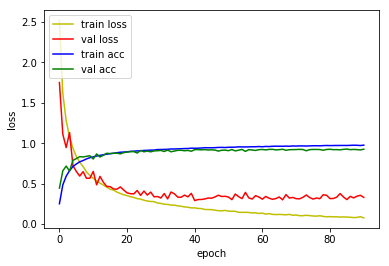

4815/4815 [==============================] - 5s 996us/sample - loss: 0.3364 - acc: 0.8997
Loss: 0.33639852784009244 Accuracy: 0.8996885

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5269 - acc: 0.2548
Epoch 00001: val_loss improved from inf to 1.74134, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/001-1.7413.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.5270 - acc: 0.2548 - val_loss: 1.7413 - val_acc: 0.4666
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5915 - acc: 0.4874
Epoch 00002: val_loss improved from 1.74134 to 1.02635, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/002-1.0263.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5915 - acc: 0.4874 - val_loss: 1.0263 - val_acc: 0.7018
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1911 - acc: 0.9407
Epoch 00025: val_loss did not improve from 0.21486
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1912 - acc: 0.9406 - val_loss: 0.2803 - val_acc: 0.9206
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9383
Epoch 00026: val_loss did not improve from 0.21486
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1945 - acc: 0.9384 - val_loss: 0.2156 - val_acc: 0.9364
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1783 - acc: 0.9441
Epoch 00027: val_loss improved from 0.21486 to 0.20645, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/027-0.2065.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1783 - acc: 0.9441 - val_loss: 0.2065 - val_acc: 0.9420
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0764 - acc: 0.9758
Epoch 00054: val_loss did not improve from 0.18696
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0764 - acc: 0.9758 - val_loss: 0.1927 - val_acc: 0.9485
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0726 - acc: 0.9767
Epoch 00055: val_loss did not improve from 0.18696
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0726 - acc: 0.9767 - val_loss: 0.2136 - val_acc: 0.9446
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9774
Epoch 00056: val_loss did not improve from 0.18696
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0716 - acc: 0.9774 - val_loss: 0.2594 - val_acc: 0.9348
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9717
Epoch 00057: val_loss did not improve from 0.18696
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9882
Epoch 00084: val_loss did not improve from 0.18696
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0384 - acc: 0.9882 - val_loss: 0.2274 - val_acc: 0.9509
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9879
Epoch 00085: val_loss did not improve from 0.18696
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0403 - acc: 0.9879 - val_loss: 0.2482 - val_acc: 0.9439
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9881
Epoch 00086: val_loss did not improve from 0.18696
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0379 - acc: 0.9881 - val_loss: 0.2248 - val_acc: 0.9446
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9879
Epoch 00087: val_loss did not improve from 0.18696
36805/36805 [===========

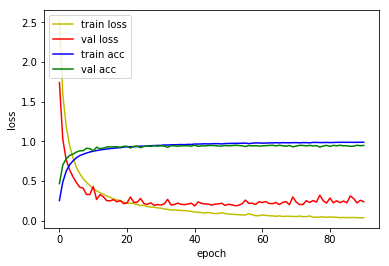

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2339 - acc: 0.9350
Loss: 0.23385951642801953 Accuracy: 0.9349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1682 - acc: 0.3634
Epoch 00001: val_loss improved from inf to 1.31152, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/001-1.3115.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 2.1680 - acc: 0.3634 - val_loss: 1.3115 - val_acc: 0.5903
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0649 - acc: 0.6627
Epoch 00002: val_loss improved from 1.31152 to 0.55624, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/002-0.5562.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.0649 - acc: 0.6627 - val_loss: 0.5562 - val_acc: 0.8297
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9733
Epoch 00025: val_loss did not improve from 0.14521
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0874 - acc: 0.9733 - val_loss: 0.1565 - val_acc: 0.9536
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9712
Epoch 00026: val_loss improved from 0.14521 to 0.14494, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/026-0.1449.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0917 - acc: 0.9712 - val_loss: 0.1449 - val_acc: 0.9574
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9737
Epoch 00027: val_loss did not improve from 0.14494
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0846 - acc: 0.9738 - val_loss: 0.1698 - val_acc: 0.9509
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - a

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9903
Epoch 00055: val_loss did not improve from 0.14494
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0323 - acc: 0.9903 - val_loss: 0.1766 - val_acc: 0.9583
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9930
Epoch 00056: val_loss did not improve from 0.14494
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0237 - acc: 0.9930 - val_loss: 0.2465 - val_acc: 0.9450
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9919
Epoch 00057: val_loss did not improve from 0.14494
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0269 - acc: 0.9919 - val_loss: 0.1814 - val_acc: 0.9546
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9924
Epoch 00058: val_loss did not improve from 0.14494
36805/36805 [===========

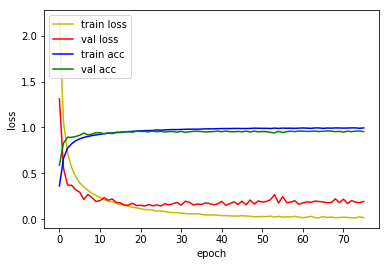

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1968 - acc: 0.9418
Loss: 0.19679422121057877 Accuracy: 0.9418484



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,528
Trainable params: 16,384,400
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.1210 - acc: 0.6667
Loss: 1.1210495365742954 Accuracy: 0.6666667

1D_CNN_5_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3364 - acc: 0.8997
Loss: 0.33639852784009244 Accuracy: 0.8996885

1D_CNN_8_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1968 - acc: 0.9418
Loss: 0.19679422121057877 Accuracy: 0.9418484
